In [12]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# If you're on a headless server, you might use:
# %matplotlib inline
# or
# %matplotlib agg

image = "00002_01.ch5"

# Path to the CH5 file
CH5_PATH = f"data/raw/idr0013/LT0001_02--ex2005_11_16--sp2005_02_17--tt17--c3/hdf5/{image}"
with h5py.File(CH5_PATH, "r") as f:
    # Print the top-level keys
    print("Top-level groups:", list(f.keys()))

Top-level groups: ['definition', 'sample']


In [13]:
def print_h5_structure(group, indent=0):
    for key in group.keys():
        item = group[key]
        if isinstance(item, h5py.Group):
            print(" " * indent, f"{key}/ (Group)")
            print_h5_structure(item, indent + 2)
        elif isinstance(item, h5py.Dataset):
            print(" " * indent, f"{key} (Dataset) shape={item.shape} dtype={item.dtype}")
        else:
            print(" " * indent, key, "(Unknown)", type(item))

with h5py.File(CH5_PATH, "r") as f:
    print_h5_structure(f)

 definition/ (Group)
   feature/ (Group)
     primary__test/ (Group)
       bounding_box (Dataset) shape=(4,) dtype=[('name', 'S16')]
       center (Dataset) shape=(2,) dtype=[('name', 'S16')]
       crack_contour (Dataset) shape=(1,) dtype=[('name', 'S512')]
       object_classification/ (Group)
         class_labels (Dataset) shape=(18,) dtype=[('label', '<i4'), ('name', 'S100'), ('color', 'S9')]
         classifier (Dataset) shape=(1,) dtype=[('name', 'S512'), ('method', 'S512'), ('version', 'S512'), ('parameter', 'S512'), ('description', 'S512')]
         features (Dataset) shape=(209,) dtype=[('object_feautres', 'S512')]
       object_features (Dataset) shape=(239,) dtype=[('name', 'S256'), ('group_00', 'S256'), ('group_01', 'S256'), ('group_02', 'S256')]
       orientation (Dataset) shape=(2,) dtype=[('name', 'S16')]
   image/ (Group)
     channel (Dataset) shape=(1,) dtype=[('channel_name', 'S50'), ('description', 'S100'), ('is_physical', '?'), ('voxel_size', '<f8', (3,)), ('col

In [15]:
IMAGE_DATASET_PATH = (
    "sample/0/plate/LT0001_02--ex2005_11_16--sp2005_02_17--tt17--c3/"
    "experiment/00002/position/1/image/channel"
)
with h5py.File(CH5_PATH, "r") as f:
    ds = f[IMAGE_DATASET_PATH]  # a h5py.Dataset object
    print("Dataset shape:", ds.shape, "dtype:", ds.dtype)

    data = ds[()]  # read all into memory
    print("Loaded data shape:", data.shape)

    # For many MitoCheck files, data.shape -> (1, 93, 1, 1024, 1344)

Dataset shape: (1, 93, 1, 1024, 1344) dtype: uint8
Loaded data shape: (1, 93, 1, 1024, 1344)


In [16]:
data_squeezed = np.squeeze(data)  # shape -> (93, 1024, 1344)
print("Squeezed shape:", data_squeezed.shape)

Squeezed shape: (93, 1024, 1344)


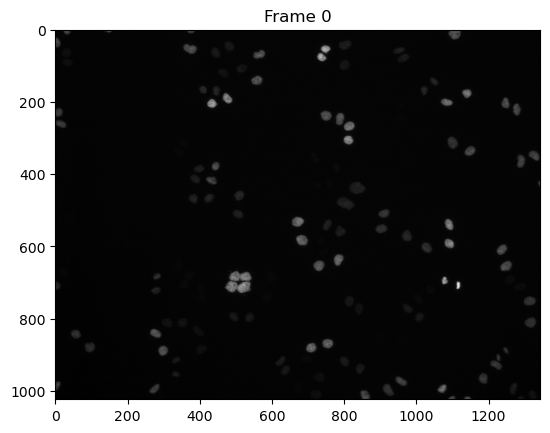

In [17]:
frame0 = data_squeezed[0]  # shape (1024, 1344)

plt.imshow(frame0, cmap='gray')
plt.title("Frame 0")
plt.show()

In [18]:
import ipywidgets as widgets
from IPython.display import display

# A slider to pick the time frame
@widgets.interact(frame=(0, data_squeezed.shape[0]-1, 1))
def show_frame(frame=0):
    plt.figure(figsize=(6,6))
    plt.imshow(data_squeezed[frame], cmap='gray')
    plt.title(f"Frame {frame}")
    plt.show()

interactive(children=(IntSlider(value=0, description='frame', max=92), Output()), _dom_classes=('widget-intera…

In [9]:
import h5py
import numpy as np

def find_ch5_image_datasets(h5file):
    """
    Search an open HDF5 file (CellH5) for datasets likely to contain raw images.
    Returns a list of dataset paths that match the typical MitoCheck shape:
    (1, T, 1, height, width) with dtype=uint8, 
    commonly named "channel" under "image/" groups.

    Args:
        h5file (h5py.File): an already opened .ch5 file in read mode

    Returns:
        A list of strings (dataset paths).
    """
    found_paths = []

    def visit_dataset(name, node):
        if isinstance(node, h5py.Dataset):
            shape = node.shape
            dtype = node.dtype
            # Check for 5D shape: (1, T, 1, Y, X) and dtype=uint8
            if (len(shape) == 5 
                and shape[0] == 1
                and shape[2] == 1
                and dtype == np.uint8):
                # Optionally also check the group name "channel" if you want:
                # if name.endswith("/channel"):
                found_paths.append(name)

    # Recursively visit all objects in the file
    h5file.visititems(visit_dataset)
    return found_paths


CH5_PATH = "data/raw/idr0013/LT0001_02--ex2005_11_16--sp2005_02_17--tt17--c3/hdf5/00002_01.ch5"
with h5py.File(CH5_PATH, "r") as f:
    image_paths = find_ch5_image_datasets(f)
    print("Found dataset paths:", image_paths)

    # If there's exactly one matching dataset, load and squeeze:
    if len(image_paths) == 1:
        ds_path = image_paths[0]
        ds = f[ds_path]
        data_5d = ds[()]  # shape like (1, T, 1, Y, X)
        data_squeezed = np.squeeze(data_5d)  # shape (T, Y, X)
        print("Loaded data shape:", data_squeezed.shape)
    else:
        print("Multiple or zero matching datasets found.")

Found dataset paths: ['sample/0/plate/LT0001_02--ex2005_11_16--sp2005_02_17--tt17--c3/experiment/00002/position/1/image/channel']
Loaded data shape: (93, 1024, 1344)
